# Experiments implementing neural networks by hand

In [46]:
import numpy as np
from numpy import random as rnd
from pyclugen import clugen
import matplotlib.pyplot as plt
import keras
from mynn import *
import tensorflow as tf

## Create train and test data with pyclugen

Text(0.5, 0.92, 'Test data')

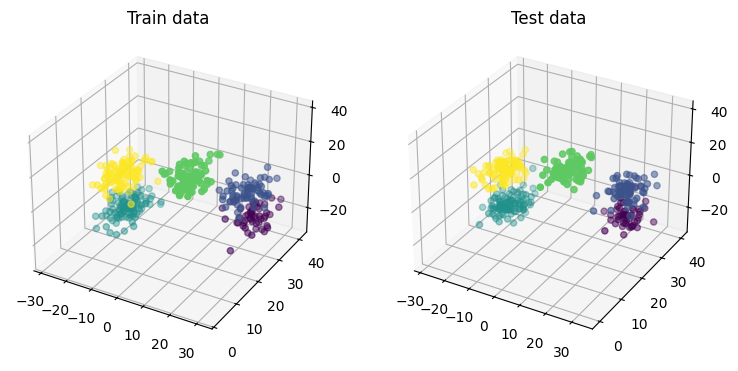

In [47]:
# Clugen parameters
ndims = 3
seed = 123
nclu = 5
npts = 400
direction = [1, 1, 0.5]
angstd = np.pi / 4
csep = [15, 15, 15]
llen = 0.1
llen_std = 0
fat = 3.5

# Generate train data
data_train = clugen(
    ndims,
    nclu,
    npts,
    direction,
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed),
)

# Generate test data, based on parameters from train data
data_test = clugen(
    ndims,
    nclu,
    npts * 2,
    data_train.directions,  # Use final directions in the train data
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed * 9 - 27),
    # Use final values from the train data
    clusizes_fn=data_train.sizes,
    clucenters_fn=data_train.centers,
    llengths_fn=data_train.lengths,
)

# Plot the train and test data
_, axs = plt.subplots(1, 2, figsize=(9, 6), subplot_kw=dict(projection="3d"))
axs[0].scatter(
    data_train.points[:, 0],
    data_train.points[:, 1],
    data_train.points[:, 2],
    c=data_train.clusters,
)
axs[0].set_title("Train data")
axs[1].scatter(
    data_test.points[:, 0],
    data_test.points[:, 1],
    data_test.points[:, 2],
    c=data_test.clusters,
)
axs[1].set_title("Test data")

## Experiments

In [48]:
# Value that output nodes are expected to have when activated or otherwise
# assuming 1-of-n output encoding
node_off = 0.1
node_on = 0.9

# Convert output to appropriate NN format output
clunn_train, _ = categ2oneofn(data_train.clusters, node_off, node_on)
clunn_test, _ = categ2oneofn(data_test.clusters, node_off, node_on)

### Compare myNN with Keras

In [49]:
# Backpropagation parameters
epochs = 100
eta = 0.05
mom = 0.15
topol = [ndims, 6, nclu]

In [50]:
########
# MyNN #
########

# Prepare hooks for registering accuracy
fitreg_mynn = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)

# Test vectorized backpropagation
mynn = vbackpropagation(
    data_train.points, clunn_train, topol, epochs, eta, mom, hooks=[fitreg_mynn], seed=45645
)

In [51]:

#########
# Keras #
#########

# Weight initializer
unif_winit = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1456)

# Using Sequential() to build layers one after another
model = keras.Sequential()

# Add input layer
model.add(keras.layers.Input(shape=(ndims,)))

# Add hidden layers
for l in range(1, len(topol) - 1):
    model.add(keras.layers.Dense(
            units=topol[l],
            activation="sigmoid",
            kernel_initializer=unif_winit,
            bias_initializer=unif_winit,
        ))

# Add output layer
model.add(keras.layers.Dense(
            units=nclu,
            activation="sigmoid",
            kernel_initializer=unif_winit,
            bias_initializer=unif_winit,
        ))

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.SGD(learning_rate=eta, momentum=mom),
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.MeanSquaredError()],
)

history = model.fit(
    x=data_train.points,
    y=clunn_train,
    epochs=epochs,
    batch_size=1,
    shuffle=False,
)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - categorical_accuracy: 0.4950 - loss: 0.1003 - mean_squared_error: 0.1003
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - categorical_accuracy: 0.5625 - loss: 0.0827 - mean_squared_error: 0.0827
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - categorical_accuracy: 0.6700 - loss: 0.0726 - mean_squared_error: 0.0726
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - categorical_accuracy: 0.7425 - loss: 0.0643 - mean_squared_error: 0.0643
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - categorical_accuracy: 0.8275 - loss: 0.0567 - mean_squared_error: 0.0567
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - categorical_accuracy: 0.8750 - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - categorical_accuracy: 0.9000 - loss: 0.0444 - mean_squared_error: 0.0444
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - categorical_accuracy: 0.9250 - lo

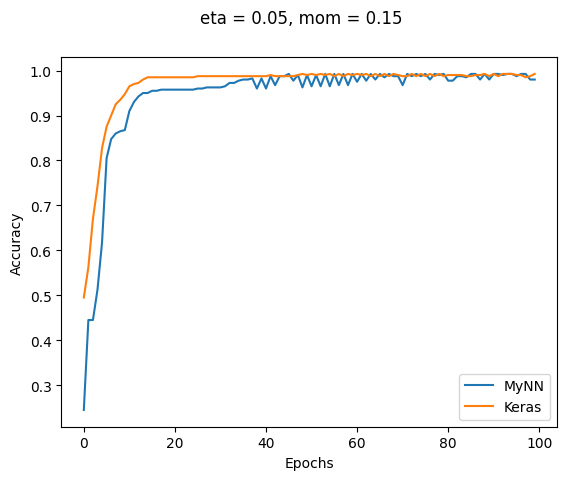

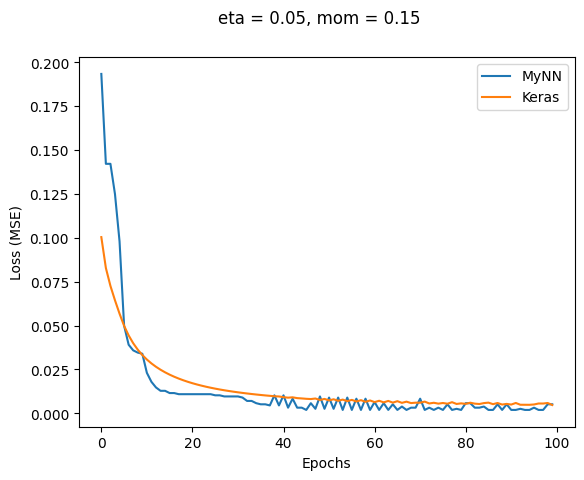

In [52]:
# Plot accuracy
plot_metric(
    epochs,
    {
        "MyNN": fitreg_mynn.accuracies,
        "Keras": history.history['categorical_accuracy'],
    },
    "Accuracy",
    f"eta = {eta}, mom = {mom}",
)

plot_metric(
    epochs,
    {
        "MyNN": fitreg_mynn.losses,
        "Keras": history.history['loss'],
    },
    "Loss (MSE)",
    f"eta = {eta}, mom = {mom}",
)

In [53]:
mynn

[array([[ 0.05737561, -0.0335507 , -0.03729025, -0.05958812,  0.02298302,
          0.14842134],
        [ 0.1022436 , -0.42461836, -0.03905196,  0.52130258,  0.44599824,
         -0.05347265],
        [ 0.42344739,  0.01217026,  0.38105515, -0.03081962, -0.00199066,
          0.64681451],
        [ 0.09618025, -0.03566132, -0.38637072, -0.90740655,  0.04389495,
          1.61605682]]),
 array([[-0.4215996 , -2.06900291, -0.60549941,  0.39657828, -0.79992827],
        [-0.25927817, -1.97715447, -0.49359682,  0.3192343 , -0.86264559],
        [-1.91343615, -1.81589671,  1.7346606 , -0.82047544,  1.03011658],
        [ 0.34956047,  1.31069794, -0.23735236, -2.35786598,  0.959751  ],
        [ 0.22744223,  2.00755178,  1.51796047, -1.50624427, -2.31803967],
        [ 1.42093918, -0.43056187, -1.95382305,  0.87533271, -1.93217788],
        [-3.03397462,  2.57618765, -2.44366169,  0.3723529 ,  1.68305861]])]

In [55]:
list(map(np.shape, mynn))

[(4, 6), (7, 5)]

In [54]:
model.weights

[<Variable path=sequential_5/dense_10/kernel, shape=(3, 6), dtype=float32, value=[[-0.03224016  0.5066988   0.06662156 -0.4209038   0.44919795 -0.11914641]
  [ 0.37509823 -0.03064405  0.4209915   0.02433433 -0.00239167  0.6025865 ]
  [-0.38945127 -0.86944413  0.11966765 -0.00432923  0.04528685  1.6538035 ]]>,
 <Variable path=sequential_5/dense_10/bias, shape=(6,), dtype=float32, value=[ 0.014838   -0.08156292  0.04986681 -0.0298151   0.03837205  0.20239817]>,
 <Variable path=sequential_5/dense_11/kernel, shape=(6, 5), dtype=float32, value=[[ 0.38757196  1.3697017  -0.22979419 -2.3814888   0.80279493]
  [ 0.18708393  1.9377477   1.418322   -1.4870263  -2.1583169 ]
  [-0.3403834  -1.9335158  -0.4354341   0.36690047 -0.8209704 ]
  [-1.8567939  -1.8324301   1.6600397  -0.7075697   1.1037511 ]
  [ 1.4744402  -0.3985272  -2.032713    0.9605886  -2.0245757 ]
  [-3.0268538   2.5491269  -2.547383    0.3487607   1.8474119 ]]>,
 <Variable path=sequential_5/dense_11/bias, shape=(5,), dtype=float32